# Import packages and set options (pick city next step)

In [1]:
print('Importing packages...')
import os
import pandas
import numpy as np
import time
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import geopandas
import scipy.stats
#from pprint import pprint
import io
from shapely.ops import unary_union
from shapely.geometry import box, Polygon, LineString, MultiLineString

thisdir = '/home/idies/workspace/21cc/raddick/community_reinvestment_act/'
data_dir = thisdir + 'city_data/'
figdir = thisdir + 'figures/'

baltimore_shapefile_basedir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'
census_shapefile_tiger_basedir = '/home/idies/workspace/21cc/Data/Census/Shapefiles/TIGER/'

earliest_year = 2012
latest_year = 2022

check_tract_consistency = True
show_water = True

# ANALYSIS OPTIONS
sb_jobs_lower_limit = 10
pop_lower_limit = 1000
tol = 8100  # Tolerance for declaring a tract is contained in a city council district
summary = {}
equal_area_proj = 2163 #{'init': 'epsg:2163'}   # https://epsg.io/2163


# MAPPING OPTIONS
scale = 1
show_tract_labels = False
manual_colorbar = True

thecolormap = 'Greys'

show_water = True
no_data_hatch = '/'  # one of {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
water_hatch = '|'    # one of {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}
not_in_city_hatch = 'x'    # one of {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'}

show_plot_labels = True

g = 0

print('ok')

Importing packages...
ok


# Pick city

In [2]:
s = time.time()
city = 'Baltimore'

# Default values will be changed for specific citites if needed
top_of_color_scale = 300000
color_scale_tick_interval = 50000
color_scale_unit = 'thousand'


if (city == 'Cleveland'):
    projection = {'init': 'EPSG:3734'}
    thestate = 39
    top_of_color_scale = 3000000
    color_scale_tick_interval = 500000
    color_scale_unit = 'million'
elif (city == 'Baltimore'):
    projection = {'init': 'EPSG:6487'}
    thestate = 24
    top_of_color_scale = 100000 #450000
    color_scale_tick_interval = 20000
    color_scale_unit = 'thousand'
    #color_scale_tick_interval = 50000    
elif (city == 'Washington D.C.'):
    #projection = {'init': 'EPSG:6487'}
    projection = {'init': 'EPSG:3857'}
    thestate = 11
elif (city == 'Detroit'):
    projection = {'init': 'EPSG:2253'}
    thestate = 26
    top_of_color_scale = 900000
    color_scale_tick_interval = 100000
elif (city == 'Philadelphia'):
    thestate = 42
    projection = {'init': 'EPSG:2272'}
    top_of_color_scale = 400000
    color_scale_tick_interval = 50000
elif (city == 'Pittsburgh'):
    thestate = 42
    projection = {'init': 'EPSG:2272'}
    top_of_color_scale = 350000
    color_scale_itck_interval = 50000
elif (city == 'St. Louis'):
    thestate = 29
    projection = {'init': 'EPSG:6512'}
    top_of_color_scale = 350000
    color_scale_tick_interval = 50000
    
elif (city == 'Newark'):
    thestate = 34
    projection = {'init': 'EPSG:3424'}
    top_of_color_scale = 350000
    color_scale_itck_interval = 50000

else:
    print('Pick a city. Possible values:\n\tBaltimore, Washington D.C., Detroit, Newark, St. Louis, Richmond, San Francisco, Cleveland, Philadelphia, Pittsburgh\n')
e = time.time()
g = g + (e-s)
print('Selected {0:}!'.format(city)) 

Selected Baltimore!


# Process to make a dataframe we can map

## Get raw data

In [3]:
# # BALTIMORE: Starting in 2020, census tracts 1801 and 1802 were combined into 2806

s = time.time()
print('loading numerical data...')
city_name_parsed = city.replace(".","").replace(" ","_").lower()
raw_data_df = pandas.read_csv(data_dir+'{0:}_{1:.0f}_{2:.0f}_year_by_year.csv'.format(city_name_parsed, earliest_year, latest_year))
raw_data_df = raw_data_df.set_index(['GEOID', 'year'])

#raw_data_df = raw_data_df.drop(['county.1', 'census_tract.1'], axis=1)  # drop duplicate columns

# # print('\n')
# # e = time.time()
# # g = g + (e-s)

# # #print('Read {0:,.0f} rows by {1:,.0f} columns in {2:,.1f} seconds!'.format(raw_data_df.shape[0], raw_data_df.shape[1], e-s))

print('Getting shapefiles...')
theyears = raw_data_df.index.get_level_values('year').drop_duplicates().sort_values(ascending=False).tolist()

shapefiles_gdf = geopandas.GeoDataFrame()
for thisyear in theyears:
    print('\t{0:.0f}...'.format(thisyear))
    thisfile = '{0:}{1:.0f}/TRACT/tl_{1:.0f}_{2:02d}_tract.shp'.format(census_shapefile_tiger_basedir, thisyear, thestate)
    gdfi = geopandas.read_file(thisfile)
    gdfi = gdfi[gdfi['COUNTYFP'] == '510']  # Baltimore City
    gdfi = gdfi.assign(year = thisyear)
    gdfi.loc[:, 'GEOID'] = gdfi['GEOID'].apply(lambda x: '14000US'+x)
    this_year_geoid_list = raw_data_df.xs(thisyear, level='year').sort_index().index.tolist()
    gdfi = gdfi[gdfi['GEOID'].isin(this_year_geoid_list)]
    shapefiles_gdf = pandas.concat((shapefiles_gdf, gdfi), axis=0)
shapefiles_gdf = shapefiles_gdf.set_index(['GEOID', 'year'])



# print('backing up...')
# raw_data_df_bk = raw_data_df
# shapefiles_gdf_bk = shapefiles_gdf

e = time.time()
g += e-s

print('Read {0:,.0f} rows by {1:,.0f} columns in {2:,.1f} seconds!'.format(raw_data_df.shape[0], raw_data_df.shape[1]+shapefiles_gdf.shape[1], e-s))



loading numerical data...
Getting shapefiles...
	2022...
	2021...
	2020...
	2019...
	2018...
	2017...
	2016...
	2015...
	2014...
	2013...
	2012...
Read 2,194 rows by 381 columns in 8.1 seconds!


# Which census tracts changed, when?

How many tracts per year?
	2012: found 200 tracts!
	2013: found 200 tracts!
	2014: found 200 tracts!
	2015: found 200 tracts!
	2016: found 200 tracts!
	2017: found 200 tracts!
	2018: found 200 tracts!
	2019: found 200 tracts!
	2020: found 198 tracts!
	2021: found 198 tracts!
	2022: found 198 tracts!


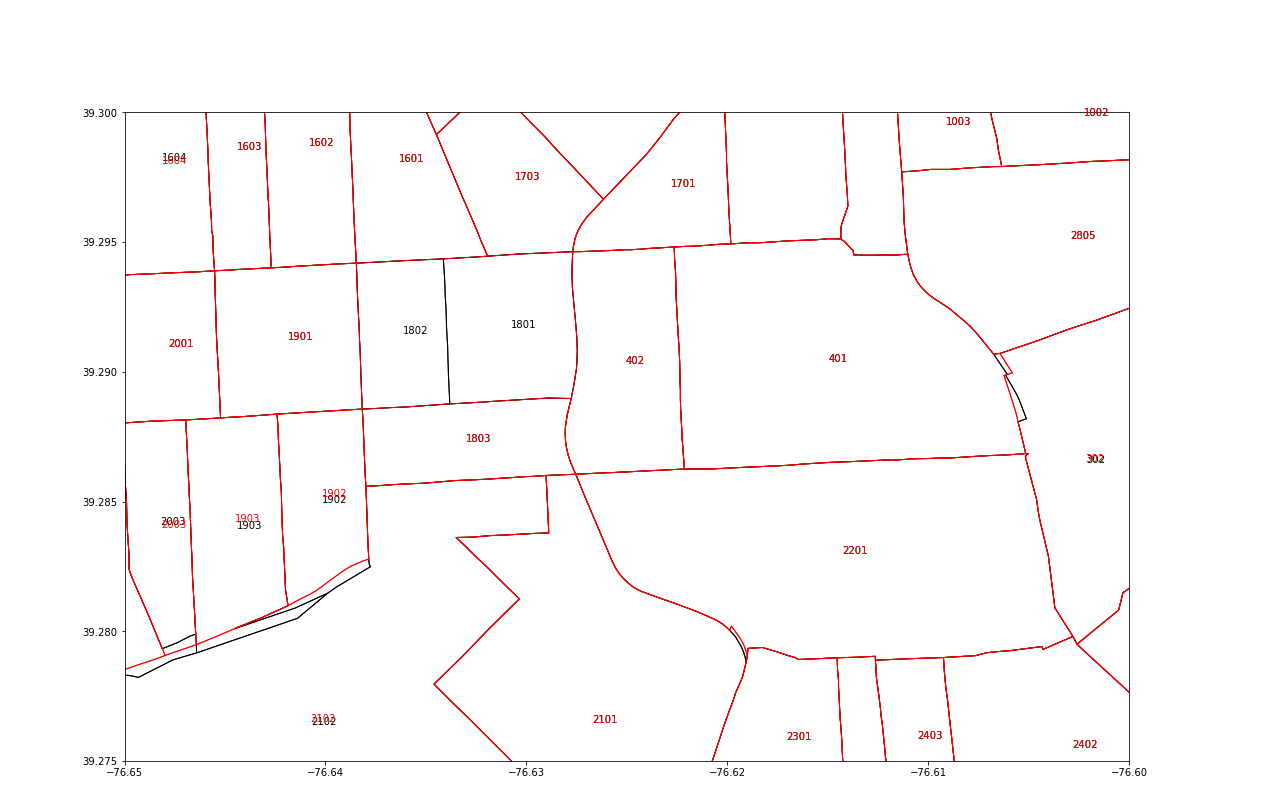

In 2020 but not in 2019:  []
In 2019 but not in 2020:  ['14000US24510180100', '14000US24510180200']


In [4]:
# print('getting from backup...')
# raw_data_df = pandas.DataFrame()
# shapefiles_gdf = pandas.DataFrame()

# raw_data_df = raw_data_df_bk
# shapefiles_gdf = shapefiles_gdf_bk
xlim = [-76.65,-76.6]
ylim = [39.275,39.3]
plot_geo = box(xlim[0], ylim[0], xlim[1], ylim[1])


print('How many tracts per year?')
theyears = shapefiles_gdf.index.get_level_values(level='year').drop_duplicates().sort_values().tolist()
for thisyear in theyears:
    print('\t{0:}: found {1:,.0f} tracts!'.format(thisyear, len(shapefiles_gdf.xs(thisyear, level='year'))))


tracts_2019_gdf = shapefiles_gdf.xs(2019, level='year')
tracts_2020_gdf = shapefiles_gdf.xs(2020, level='year')


fig, ax = plt.subplots(1,1, figsize=(18,18))
tracts_2019_gdf.plot(ax=ax, color='none', edgecolor='black')
tracts_2020_gdf.plot(ax=ax, color='none', edgecolor='red')


for ix, thisrow in tracts_2019_gdf[tracts_2019_gdf.geometry.apply(lambda x: x.intersects(plot_geo))].iterrows():
    annotator = '{0:}'.format(thisrow['NAME'])
    ax.annotate(annotator, 
                (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
               color='black')
for ix, thisrow in tracts_2020_gdf[tracts_2020_gdf.geometry.apply(lambda x: x.intersects(plot_geo))].iterrows():
    annotator = '{0:}'.format(thisrow['NAME'])
    ax.annotate(annotator, 
                (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
               color='red')
    

ax.set_xlim(xlim)
ax.set_ylim(ylim)


plt.show()

tracts_2020_but_not_2019 = tracts_2020_gdf[~tracts_2020_gdf.index.isin(tracts_2019_gdf.index.tolist())].index.tolist()
tracts_2019_but_not_2020 = tracts_2019_gdf[~tracts_2019_gdf.index.isin(tracts_2020_gdf.index.tolist())].index.tolist()

print('In 2020 but not in 2019: ', tracts_2020_but_not_2019)
print('In 2019 but not in 2020: ', tracts_2019_but_not_2020)

# 2010 Census: Poppelton was tracts 1801.00 and 1802.00
# 2020 Census: Poppelton is tract 2806.00




# Get summary info for tracts

## Create empty dataframe with 2020 tracts

In [7]:
s = time.time()
print('creating summary data frame...')
tract_ix = shapefiles_gdf.xs(latest_year, level='year').sort_index().index

if (city == 'Baltimore'):
    print('Baltimore: adding census tract 2806.00 (combined 1801.00/1901.00 starting in 2020)...')
    tract_ix = tract_ix.union(['14000US24510280600'])

data_df = pandas.DataFrame(data=None, index=tract_ix)
data_df.index.name = 'GEOID'

e = time.time()
g += e-s
print('Got {0:,.0f} modern tracts in {1:,.1f} seconds!'.format(data_df.shape[0], e-s))


creating summary data frame...
Baltimore: adding census tract 2806.00 (combined 1801.00/1901.00 starting in 2020)...
Got 199 modern tracts in 0.0 seconds!


## Find each tract's total loans

In [ ]:


# print('adding tract and loan info columns...')
# info_columns = ['state', 'county', 'census_tract', 'city_name', 'msa', 'loan_type', 'action_taken_type']
# data_df = data_df.join(raw_data_df.xs(latest_year, level='year')[info_columns], how='outer')

print('summing loan columns...')
sum_columns = []
sum_columns += ['nLoans1', 'amtLoans1_adj', 'nLoans100k', 'amtLoans100k_adj', 'nLoans250k', 'amtLoans250k_adj']
sum_columns += ['nLoansToSmallest', 'amtLoansToSmallest_adj', 'nLoans', 'amtLoans_adj']
sum_columns += ['nWorkingLoans', 'amtWorkingLoans_adj']
sum_columns += ['nLoans1_per_totaljob', 'amtLoans1_per_totaljob_adj']
sum_columns += ['nLoans100k_per_totaljob', 'amtLoans100k_per_totaljob_adj']
sum_columns += ['nLoans250k_per_totaljob', 'amtLoans250k_per_totaljob_adj']
sum_columns += ['nLoansToSmallest_per_totaljob', 'amtLoansToSmallest_per_totaljob_adj']
sum_columns += ['nLoans_per_totaljob', 'amtLoans_per_totaljob_adj']
sum_columns += ['nWorkingLoans_per_totaljob', 'amtWorkingLoans_per_totaljob_adj']
sum_columns += ['nLoans1_per_sbjob', 'amtLoans1_per_sbjob_adj']
sum_columns += ['nLoans100k_per_sbjob', 'amtLoans100k_per_sbjob_adj']
sum_columns += ['nLoans250k_per_sbjob', 'amtLoans250k_per_sbjob_adj']
sum_columns += ['nLoansToSmallest_per_sbjob', 'amtLoansToSmallest_per_sbjob_adj']
sum_columns += ['nLoans_per_sbjob', 'amtLoans_per_sbjob_adj']
sum_columns += ['nWorkingLoans_per_sbjob', 'amtWorkingLoans_per_sbjob_adj']
data_df = data_df.join(raw_data_df.xs(latest_year, level='year')[sum_columns], how='left')


e = time.time()
g += e-s
print('Summarized {0:,.0f} variables for {1:,.0f} all-years-tracts in {2:,.1f} seconds!'.format(data_df.shape[1], data_df.shape[0], e-s))
#data_df

## Add CRA info and jobs

In [ ]:
# print('getting from backup...')
# data_df = pandas.DataFrame()
# data_df = data_df_bk
s = time.time()

print('adding CRA info columns...')
cra_info_columns = ['income_group_code', 'income_group', 'cra_level']

data_df = data_df.join(raw_data_df.xs(latest_year, level='year')[cra_info_columns], how='outer')

for thiscol in cra_info_columns:
    data_df = data_df.rename(columns={thiscol: '{0:}_{1:.0f}'.format(thiscol, latest_year)})

print('adding jobs columns...')

jobs_columns = []
jobs_columns += ['total_jobs', 'sb_jobs', 'C000', 'CA01', 'CA02', 'CA03']
jobs_columns += ['CE01', 'CE02', 'CE03', 'CNS01', 'CNS02', 'CNS03', 'CNS04', 'CNS05']
jobs_columns += ['CNS06', 'CNS07', 'CNS08', 'CNS09', 'CNS10', 'CNS11', 'CNS12']
jobs_columns += ['CNS13', 'CNS14', 'CNS15', 'CNS16', 'CNS17', 'CNS18', 'CNS19', 'CNS20']
jobs_columns += ['CR01', 'CR02', 'CR03', 'CR04', 'CR05', 'CR07', 'CT01', 'CT02']
jobs_columns += ['CD01', 'CD02', 'CD03', 'CD04', 'CS01', 'CS02']
jobs_columns += ['CFA01', 'CFA02', 'CFA03', 'CFA04', 'CFA05']
jobs_columns += ['CFS01', 'CFS02', 'CFS03', 'CFS04', 'CFS05']

data_df = data_df.join(raw_data_df.xs(latest_year, level='year')[jobs_columns], how='outer')

e = time.time()
g += e-s
print('Summarized {0:,.0f} variables for {1:,.0f} all-years-tracts in {2:,.1f} seconds!'.format(data_df.shape[1], data_df.shape[0], e-s))

data_df



In [ ]:
[x for x in raw_data_df.columns.tolist() if x not in data_df.columns.tolist()]

In [ ]:


# print('\n')
# print('Tracts with data but no shapefiles...')
# print(data_df[data_df['state'].isnull()].index.tolist())
# print('\n')
# print('Tracts with shapefiles but no data...')
# print(data_df[data_df['nLoans1'].isnull()].index.tolist())
# print('\n')

# # # # # #data_df.loc['14000US24510280600']
# # # # # data_columns = data_df.columns[3:]
# # # # # #for thiscol in data_columns:

# # # # # data_df[sum_columns].loc[['14000US24510180100', '14000US24510180200']]
# # # # raw_data_df[sum_columns]
# # # pre_2020_tracts = ['14000US24510180100', '14000US24510180200']
# # # post_2020_tracts = ['14000US24510280600']

# # # # raw_data_df
# # # raw_data_df[raw_data_df.index.get_level_values('GEOID').isin(post_2020_tracts)][sum_columns]
# # # #data_df[data_df.index.isin(post_2020_tracts)]
# # # # for ix, thisrow in raw_data_df[raw_data_df.index.get_level_values('GEOID').isin(['14000US24510180100', '14000US24510180200'])][sum_columns].reset_index().groupby('year').sum().iterrows():
# # # #     for thiscol in sum_columns:
# # # #         data_df.loc[()]


# # # #data_df.loc[~data_df.index.isin(post_2020_tracts)] = 



# # # for thiscol in sum_columns:
# # #     data_df[thiscol] = np.nan
# # #     data_df.loc[~data_df.index.isin(post_2020_tracts), thiscol] = raw_data_df.reset_index()[~raw_data_df.reset_index()['GEOID'].isin(pre_2020_tracts)].groupby('GEOID')[thiscol].sum()
# # #     #for ix in post_2020_tracts:
# # #     print(thiscol)
# # #     #print(raw_data_df[raw_data_df.index.get_level_values('GEOID').isin(['14000US24510180100', '14000US24510180200'])][thiscol].reset_index().groupby('year').sum())
    
# # # #data_df

# # # raw_data_df.reset_index()[raw_data_df.reset_index()['GEOID'].isin(pre_2020_tracts)]
# # #raw_data_df[raw_data_df['census_tract'] == 2806]

In [ ]:




# # census count errors
# new_columns = []
# new_columns += ['pop_total_err','pop_by_race_total_err','pop_white_err','pop_black_err']
# new_columns += ['total_households_err','white_householders_err','black_householders_err','female_householders_err']
# new_columns += ['total_housing_units_err','occupied_housing_units_err','vacant_housing_units_err']
# new_columns += ['educated_serr','unemployed_16plus_err','poverty_past_12_months_err','mfi_err'] # high school graduates (ages 25+), unemployed, in poverty, MFI, travel time to work
# new_columns += ['owner_occ_housing_units_err','median_home_value_err', 'median_year_built_err'] # home
# new_columns += ['pop_25plus_err','labor_force_16plus_err','poverty_status_known_err']

# # census percentages and their errors
# new_columns += ['pct_white','pct_black','pct_white_householders','pct_black_householders','pct_female_householders']
# new_columns += ['peducated','pct_unemployed','pct_poverty','pct_vacant', 'pct_household_familiy', 'pct_rent']
# new_columns += ['pct_white_serr','pct_black_serr','pct_white_householders_serr','pct_black_householders_serr','pct_female_householders_serr']
# new_columns += ['peducated_serr','pct_unemployed_serr','pct_poverty_serr','pct_vacant_serr', 'pct_household_familiy_serr', 'pct_rent_serr']
# new_columns += ['household_type_family_err', 'household_type_nonfamily_err', 'household_type_total_err', 'tenure_rent_err', 'tenure_total_err']


# print('adding demographics...')

# demographics_columns = []
# demographics_columns += ['pop_total', 'pop_by_race_total', 'pop_white', 'pop_black']
# demographics_columns += ['total_households', 'white_householders', 'black_householders', 'female_householders']
# demographics_columns += ['total_housing_units', 'occupied_housing_units', 'vacant_housing_units']
# demographics_columns += ['educated', 'unemployed_16plus', 'poverty_past_12_months', 'mfi_adj']
# demographics_columns += ['owner_occ_housing_units', 'median_home_value', 'year_built', 'median_year_built']
# demographics_columns += ['pop_25plus', 'labor_force_16plus', 'poverty_status_known']
# demographics_columns += ['household_type_family', 'household_type_nonfamily', 'household_type_total', 'tenure_rent', 'tenure_total']

# demographics_columns += ['pop_total_err', 'pop_by_race_total_err', 'pop_white_err', 'pop_black_err']
# demographics_columns += ['total_households_err', 'white_householders_err', 'black_householders_err', 'female_householders_err']
# demographics_columns += ['total_housing_units_err', 'occupied_housing_units_err', 'vacant_housing_units_err']
# demographics_columns += ['educated_serr', 'unemployed_16plus_err', 'poverty_past_12_months_err', 'mfi_err']
# demographics_columns += ['owner_occ_housing_units_err', 'median_home_value_err', 'pop_25plus_err', 'labor_force_16plus_err', 'poverty_status_known_err']
# demographics_columns += ['household_type_family_err', 'household_type_nonfamily_err', 'household_type_total_err', 'tenure_rent_err', 'tenure_total_err']

# demographics_columns += ['pct_white', 'pct_black']
# demographics_columns += ['pct_white_householders', 'pct_black_householders', 'pct_female_householders']
# demographics_columns += ['peducated', 'pct_unemployed', 'pct_poverty', 'pct_vacant']
# demographics_columns += ['pct_white_serr', 'pct_black_serr']
# demographics_columns += ['pct_white_householders_serr', 'pct_black_householders_serr', 'pct_female_householders_serr']
# demographics_columns += ['peducated_serr', 'pct_unemployed_serr', 'pct_poverty_serr', 'pct_vacant_serr']
# demographics_columns += ['pct_household_family', 'pct_rent', 'pct_household_family_serr', 'pct_rent_serr']
# data_df = pandas.concat((data_df, raw_data_df[demographics_columns].xs(latest_year, level='year')), axis=1)

# for thiscol in demographics_columns:
#     data_df = data_df.rename(columns = {thiscol: thiscol+'_{0:.0f}'.format(latest_year)})

# geo_info_columns = []
# # if (city == 'Baltimore'):
# #     geo_info_columns += ['split_county_indicator', 'population_classification', 'CSA2020']
# # else:
# geo_info_columns += ['split_county_indicator', 'population_classification']
# geo_info_columns += ['NAMELSAD', 'MTFCC', 'FUNCSTAT']
# geo_info_columns += ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']

# data_df = pandas.concat((data_df, raw_data_df[geo_info_columns].xs(latest_year, level='year')), axis=1)

# for thiscol in geo_info_columns:
#     data_df = data_df.rename(columns = {thiscol: thiscol+'_{0:.0f}'.format(latest_year)})

# data_df = data_df.assign(geometry = None)



# data_df.loc[:, 'geometry'] = shapefiles_gdf.xs(latest_year, level='year')['geometry'].tolist()
# data_gdf = geopandas.GeoDataFrame(data_df, crs=shapefiles_gdf.crs, geometry='geometry')

# # # if (city == 'Baltimore'):
# # #     baltimore_shapefiles_gdf = baltimore_shapefiles_gdf.to_crs(tracts_included_gdf.crs)

# e = time.time()
# g = g + (e-s)

# print('\nDone in {0:,.1f} seconds!'.format(e-s))

# # shapefiles_gdf.index#.shape   # 1996

# data_gdf.index.name = 'GEOID'

# # #data_df#[~data_df.index.isin(shapefiles_gdf.index.get_level_values(0))]

# # #shapefiles_gdf.xs(2020, level='year')
# data_gdf
# #data_df[data_df['state'].isnull()]

## Read water area shapefiles

In [ ]:
s = time.time()
show_water = True
if (show_water):
    print('reading water files...')
    water_dir = census_shapefile_tiger_basedir+"{0:.0f}/AREAWATER/{1:}/".format(latest_year, 'md')
    water_files = [water_dir+x for x in os.listdir(water_dir) if ('tl_{0:.0f}_{1:02d}'.format(latest_year,thestate) in x) and (x[-3:] == 'shp')]
    
    water_gdf = geopandas.GeoDataFrame()
    for i in range(0, len(water_files)):
        if ((np.mod(i,10) == 0) | (i == len(water_files)-1)):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_files)))
        water_gdf = pandas.concat((water_gdf, geopandas.read_file(water_files[i])))
    water_gdf = water_gdf.to_crs(data_gdf.crs)
    print('\tfinding water within city...')
    city_water_gdf = geopandas.overlay(water_gdf, geopandas.GeoDataFrame(data=[[unary_union(data_gdf.geometry.tolist())]], columns=['geometry'], crs=data_gdf.crs, geometry='geometry'), how='intersection')

    if (city == 'Baltimore'):
        #city_water_gdf.plot(ax=ax, color='orange')
        #print(city_water_gdf.loc[city_water_gdf.to_crs(equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).index.tolist()])
        baltimore_water_gdf = city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'hbr' in str(x).lower())]#.plot(ax=ax, color='cyan')                
        baltimore_water_gdf = pandas.concat((baltimore_water_gdf, city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'patapsco' in str(x).lower())]), axis=0, sort=False)#.plot(ax=ax, color='cyan')
        baltimore_water_gdf = pandas.concat((baltimore_water_gdf, city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'curtis' in str(x).lower())]), axis=0, sort=False)#.plot(ax=ax, color='cyan')
        baltimore_water_gdf = pandas.concat((baltimore_water_gdf, city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'colgate' in str(x).lower())]), axis=0, sort=False)#.plot(ax=ax, color='cyan')
        baltimore_water_gdf = pandas.concat((baltimore_water_gdf, city_water_gdf[city_water_gdf['HYDROID'] == '110190589339']), axis=0, sort=False)#.plot(ax=ax, color='cyan')   # Inner Harbor
        baltimore_water_gdf = pandas.concat((baltimore_water_gdf, city_water_gdf[city_water_gdf['HYDROID'].isin(['110190589337','110190589300'])]), axis=0, sort=False)#.plot(ax=ax, color='cyan')   # Two other spots in the harbor
        city_water_gdf = baltimore_water_gdf
    elif (city == 'Washington D.C.'):
        city_water_gdf = city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: ('potomac' in str(x).lower()) | ('anacostia' in str(x).lower()) | ('washington chnnl' in str(x).lower()))]#.plot(ax=ax, color='cyan')
    elif (city == 'Cleveland'):
        city_water_gdf = city_water_gdf.loc[city_water_gdf.to_crs(epsg=equal_area_proj).geometry.area.sort_values(ascending=False).head(3).index.tolist()]
    elif (city == 'Detroit'):
        detroit_water_gdf = city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'riv' in str(x).lower())]
        detroit_water_gdf = pandas.concat((detroit_water_gdf, city_water_gdf[city_water_gdf['HYDROID'].isin(['1107295328725','1107295323725'])]), axis=0, sort=False)
        city_water_gdf = detroit_water_gdf
    elif (city == 'Philadelphia'):
        philadelphia_water_gdf = city_water_gdf[
            city_water_gdf['FULLNAME'].apply(lambda x: (str(x).lower()[-3:] == 'riv') | (str(x).lower()[-3:] == 'crk')) 
        ]
        philadelphia_water_gdf = pandas.concat((philadelphia_water_gdf, city_water_gdf[city_water_gdf['HYDROID'].isin(['110687646436','110687646470','1103689733768','1103017430436',])]), axis=0, sort=False)
        city_water_gdf = philadelphia_water_gdf
    elif (city == 'Pittsburgh'):
        city_water_gdf = city_water_gdf[
            city_water_gdf['FULLNAME'].apply(lambda x: str(x).lower()[-3:] == 'riv') 
        ]
    elif (city == 'St. Louis'):
        city_water_gdf = city_water_gdf[(city_water_gdf['FULLNAME'] == 'Mississippi Riv') | (city_water_gdf['FULLNAME'] == 'River Des Peres')]
    else:
        pass
else:
    print('not showing water in this script; to show water, set show_water = True')

print('backing up all geodataframes...')
data_gdf_bk = data_gdf
# tracts_included_gdf_bk = tracts_included_gdf
# if (city == 'Baltimore'):
#    baltimore_shapefiles_gdf_bk = baltimore_shapefiles_gdf
#city_water_gdf_bk = city_water_gdf

e = time.time()
g = g + (e-s)

print('Done in {0:,.1f} seconds!'.format(e-s))

# # for ix, thisrow in city_water_gdf.iterrows():
# #     ax.annotate(thisrow['HYDROID'], 
# #                  xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                  xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y),
# #                 backgroundcolor='white'
# #                 )


In [ ]:

# thecolormap = 'magma'
# # xmin = 2660000
# # xmax = 2670000
# # ymin = 200000
# # ymax = 220000

# print('getting from backup...')
# # all_tracts_gdf = all_tracts_gdf_bk
# # tracts_included_gdf = tracts_included_gdf_bk
# #city_water_gdf = city_water_gdf_bk

# fig, ax = plt.subplots(1,1,figsize=(24*scale,24*scale))
# #data_gdf.plot(ax=ax, color='pink', linewidth=2*scale)
# #tracts_included_gdf.plot(ax=ax, column='amtWorkingLoans_per_sbjob_adj', cmap=thecolormap, edgecolor='white', linewidth=2*scale)
# data_gdf.plot(ax=ax, column='amtWorkingLoans_per_sbjob_adj', cmap=thecolormap, edgecolor='white', linewidth=2*scale)

# city_water_gdf.plot(ax=ax, color='orange')
# #city_water_gdf[(city_water_gdf['FULLNAME'] == 'Mississippi Riv') | (city_water_gdf['FULLNAME'] == 'River Des Peres')].plot(ax=ax, color='cyan')


# plt.show()
# # city_water_gdf.loc[
# #     city_water_gdf.to_crs(epsg=equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).head(2).index.tolist()
# # ]




In [ ]:

# city_water_gdf.plot(ax=ax, color='cyan')

# # city_water_gdf[
# #             city_water_gdf['FULLNAME'].apply(lambda x: str(x).lower()[-3:] == 'riv') 
# #         ].plot(ax=ax, color='cyan')

# # city_water_gdf.loc[
# #     city_water_gdf.to_crs(equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).head(8).index.tolist()
# # ].plot(ax=ax, color='cyan')


# #city_water_gdf.plot(ax=ax, color='cyan')


# # u = []
# # for ix, thisrow in city_water_gdf.iterrows():
# # #     print(thisrow.geometry.centroid.coords[0][0])
# # #     print(thisrow.geometry.centroid.coords[0][1])
# # #     print('\n')
# #     if (((thisrow.geometry.centroid.coords[0][0] >= xmin) & (thisrow.geometry.centroid.coords[0][0] <= xmax)) & ((thisrow.geometry.centroid.coords[0][1] >= ymin) & (thisrow.geometry.centroid.coords[0][1] <= ymax))):
# #         ax.annotate(thisrow['HYDROID'], 
# #                      xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                      xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y),
# #                     backgroundcolor='white'
# #                     )
# #         u.append(thisrow['HYDROID'])
# # plt.xlim([xmin,xmax])
# # plt.ylim([ymin,ymax])
# plt.show()




# city_water_gdf.loc[
#     city_water_gdf.to_crs(equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).index.tolist()
# ]

# #city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: (str(x).lower()[-3:] == 'riv') | (str(x).lower()[-3:] == 'crk'))]
# #u
print('ok')

## Find city enclaves and exclaves

In [ ]:
union_gdf = geopandas.GeoDataFrame(data=[[unary_union(data_gdf.geometry.tolist())]], columns=['geometry'], crs=data_gdf.crs, geometry='geometry')

if (len(union_gdf.geometry.boundary) == 1):
    print('no enclaves or exclaves!')
print('ok')

In [ ]:

# union_gdf = geopandas.GeoDataFrame(unary_union(all_tracts_gdf.geometry.tolist()), columns=['geometry'], crs=all_tracts_gdf.crs, geometry='geometry')

# boundary_raw_gdf = geopandas.GeoDataFrame(data=union_gdf.geometry.boundary, columns=['geometry'], crs=union_gdf.crs, geometry='geometry')

# boundary_list = []
# #boundary_gdf = geopandas.GeoDataFrae(data=None, columns=['geometry'], crs=boundary_raw_gdf.crs, geometry='geometry')


# for ix, thisrow in boundary_raw_gdf.iterrows():
#     if (thisrow.geometry.type == 'MultiLineString'):
#         boundary_list = boundary_list + [x for x in thisrow.geometry.simplify(tolerance = 100)]
#     else:
#         boundary_list.append(thisrow.geometry)

# city_boundary_parts_gdf = geopandas.GeoDataFrame(data=[Polygon(x) for x in boundary_list], columns=['geometry'], crs=union_gdf.crs, geometry='geometry')

# city_boundary_parts_gdf = city_boundary_parts_gdf.assign(area = city_boundary_parts_gdf.geometry.apply(lambda x: x.area))

# city_boundary_parts_gdf = city_boundary_parts_gdf.sort_values(by='area', ascending=False).reset_index(drop=True)

# city_boundary_parts_gdf = city_boundary_parts_gdf.assign(thetype = np.nan)

# city_boundary_parts_gdf.loc[0, 'thetype'] = 'main'
# main_city_geo = city_boundary_parts_gdf[city_boundary_parts_gdf['thetype'] == 'main'].geometry.values[0]


# city_boundary_parts_gdf.loc[
#     (
#         (city_boundary_parts_gdf['thetype'].isnull()) 
#         & (city_boundary_parts_gdf.geometry.apply(lambda x: x.within(main_city_geo)))
#     ), 'thetype'] = 'enclave'

# city_boundary_parts_gdf.loc[
#     (
#         (city_boundary_parts_gdf['thetype'].isnull()) 
#         & (~city_boundary_parts_gdf.geometry.apply(lambda x: x.within(main_city_geo)))
#     ), 'thetype'] = 'exclave'

# # #city_boundary_parts_gdf.loc[city_boundary_parts_gdf[city_boundary_parts_gdf['thetype'] != 'main'].geometry.apply(lambda x: not(x.within(main_city_geo))), 'thetype'] = 'exclave'

# # fig, ax = plt.subplots(1,1)

# # union_gdf.plot(ax=ax, color='pink')
# # #all_tracts_gdf.plot(ax=ax, color='none', edgecolor='black')
# # #city_boundary_parts_gdf[city_boundary_parts_gdf['thetype'] == 'enclave'].plot(ax=ax, color='cyan', alpha=0.5)

# # plt.show()
# print(city_boundary_parts_gdf)#[city_boundary_parts_gdf['thetype'] == 'enclave']



In [ ]:
fig, ax = plt.subplots(1,1,figsize=(24*scale,24*scale))
shapefiles_gdf.plot(ax=ax, color='pink')
#tracts_included_gdf.plot(ax=ax, column='amtWorkingLoans_per_sbjob_adj', cmap=thecolormap, edgecolor='white', linewidth=2*scale)
data_gdf.plot(ax=ax, column='amtWorkingLoans_per_sbjob_adj', cmap=thecolormap, edgecolor='white', linewidth=2*scale)


# # #city_water_gdf.plot(ax=ax, color='orange')
# # print(city_water_gdf.loc[city_water_gdf.to_crs(equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).index.tolist()])
# # city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'hbr' in str(x).lower())].plot(ax=ax, color='cyan')                
# # city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'patapsco' in str(x).lower())].plot(ax=ax, color='cyan')
# # city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'curtis' in str(x).lower())].plot(ax=ax, color='cyan')
# # city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'colgate' in str(x).lower())].plot(ax=ax, color='cyan')
# # city_water_gdf[city_water_gdf['HYDROID'] == '110190589339'].plot(ax=ax, color='cyan')   # Inner Harbor
# # city_water_gdf[city_water_gdf['HYDROID'].isin(['110190589337','110190589300'])].plot(ax=ax, color='cyan')   # Two other spots in the harbor
# # # for ix, thisrow in city_water_gdf.iterrows():
# # #     ax.annotate(thisrow['HYDROID'], 
# # #                  xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# # #                  xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y),
# # #                 backgroundcolor='white'
# # #                 )



# # city_water_gdf.loc[
# #     city_water_gdf.to_crs(equal_area_proj).geometry.area.apply(lambda x: x / (1000*1000)).sort_values(ascending=False).head(5).index.tolist()
# # ].plot(ax=ax, color='cyan')

# #city_water_gdf[city_water_gdf['FULLNAME'].apply(lambda x: 'hbr' in str(x).lower())].plot(ax=ax, color='cyan')
city_water_gdf.plot(ax=ax, color='cyan')

# plt.xlim([430000,442000])
# plt.ylim([170000,180000])
plt.show()



#print('ok')

In [ ]:
s = time.time()

data_gdf['amtWorkingLoans_per_sbjob_adj'].hist()
e = time.time()
g = g + (e-s)
plt.show()

In [ ]:
s = time.time()
thecolormap = 'Greys'
print('making basic map...')

fig1, ax = plt.subplots(1,1, figsize=(48*scale, 48*scale))

# if (city == 'Pittsburgh'):
#     city_boundary_parts_gdf[city_boundary_parts_gdf['thetype'] == 'enclave'].plot(ax=ax, color='white', hatch=not_in_city_hatch, edgecolor='black')

# if (city == 'Baltimore'):
#     baltimore_shapefiles_gdf.plot(ax=ax, color='white', hatch=no_data_hatch, edgecolor='black')
# else:

print('adding legend to label hatched area(s)...')

no_data_legendizer = mpatches.Patch(facecolor='white', edgecolor='black', hatch=no_data_hatch, label='Fewer than {0:.0f} small business jobs and/or {1:.0f} people'.format(sb_jobs_lower_limit, pop_lower_limit))
legendizer_list = [no_data_legendizer]

if (show_water):
    water_legendizer = mpatches.Patch(facecolor='white', edgecolor='black', hatch=water_hatch, label='Water area')
    legendizer_list.append(water_legendizer)
# if (city == 'Pittsburgh'):
#     not_in_city_legendizer = mpatches.Patch(facecolor='white', edgecolor='black', hatch=not_in_city_hatch, label='Not part of city')
#     legendizer_list.append(not_in_city_legendizer)
    
#if (len(legendizer_list) == 3):
if ((city == 'Detroit') | (city == 'Cleveland') | (city == 'Philadelphia')):
    plt.legend(handles=legendizer_list, fontsize=52*scale, loc='lower right')
else:
    plt.legend(handles=legendizer_list, fontsize=52*scale, loc='lower left')
# else:
#     plt.legend(handles=legendizer_list, fontsize=52*scale, loc='upper left')

data_gdf.plot(ax=ax, color='white', hatch=no_data_hatch, edgecolor='black')



data_gdf.plot(ax=ax, column='amtWorkingLoans_per_sbjob_adj', 
                         cmap=thecolormap, edgecolor='black', linewidth=2*scale)

print('setting options...')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.title('{0:} census tracts (n = {1:,.0f})'.format(city, len(data_gdf)), fontsize=64*scale, y=1.04)


if (show_water):
    print('adding water layer...')
    city_water_gdf.plot(ax=ax, color='white', hatch=water_hatch, linewidth=2*scale)

print('adding colorbar...')

cax = fig1.add_axes([0.125, 0.08, 0.775, 0.03])

sm = plt.cm.ScalarMappable(cmap=thecolormap, norm=plt.Normalize(
    vmin=0, vmax=top_of_color_scale
    #vmax=tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'].max()
))
## fake up the array of the scalar mappable. Urgh...
sm._A = []

if (color_scale_unit == 'million'):
    rescalor = 1000000
elif (color_scale_unit == 'thousand'):
    rescalor = 1000
else:
    rescalor = np.nan

cbar = fig1.colorbar(sm, cax=cax, orientation='horizontal',
                     ticks=np.arange(0,top_of_color_scale+color_scale_tick_interval,color_scale_tick_interval)
                    )



cax.set_xticklabels(['${0:.1f}'.format(x/rescalor) for x in np.arange(0,top_of_color_scale+color_scale_tick_interval,color_scale_tick_interval)], fontsize=56*scale)

cbar.set_label('Total working loans per small business job ({0:} {1:.0f}USD)'.format(color_scale_unit, latest_year), fontsize=68*scale)


if (show_tract_labels):
    print('showing tract labels...')
    for ix, thisrow in tracts_included_gdf.iterrows():
        #if (ix[1] in [1803.0, 1003.0, 2603.02, 2005.0, 2008.0, 2803.02, 2709.03, 1502.0, 401.0, 1902.0, 904.0, 2802.0, 1607.0, 2102.0, 2711.01, 1602.0, 902.0, 1703.0]):#, 1510.0, 801.02, 2602.02, 1308.03, 903.0, 1903.0, 1601.0, 1308.05, 2715.03, 2715.01, 1402.0, 105.0, 2701.01, 1605.0, 2007.02, 1506.0, 2706.0, 1201.0, 1206.0, 2709.01, 2709.02, 2718.01, 804.0, 1501.0, 1308.04, 1604.0, 2602.01, 2710.01, 1202.02, 1513.0, 2602.03, 2708.02, 1303.0, 2604.02, 2404.0, 2007.01, 1603.0]):
        annotator = ''
        annotator += str(ix[1])
        annotator += '\n'
        annotator += '${0:,.0f}k'.format(thisrow['amtWorkingLoans_per_sbjob_adj']/1000)
        ax.annotate(annotator, 
                    xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    #backgroundcolor = 'white',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=24*scale,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round')
        )
    map_outfile_name = figdir+'{0:}_map_labeled.jpg'.format(city.replace('.','').replace(' ','_').lower())
else:
    map_outfile_name = figdir+'{0:}_map_unlabeled.jpg'.format(city.replace('.','').replace(' ','_').lower())

#plt.savefig(map_outfile_name, format='jpg', dpi=300*scale)
plt.show()

e = time.time()
g = g + (e-s)

print('Created map in {0:,.0f} seconds!'.format(e-s))
#city_water_gdf.head(1).T#[city_water_gdf['FULLNAME'] == 'Harbor']

print(tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'].max())
np.ceil(tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'].max()/rescalor)*rescalor



In [ ]:
s = time.time()

# print('getting from backup...')
# tracts_included_gdf = tracts_included_gdf_bk

# print('identifying tracts by poverty rate...')
# tracts_included_gdf = tracts_included_gdf.assign(poverty_class_2019 = np.nan)
# tracts_included_gdf.loc[tracts_included_gdf['pct_poverty_2019'] > 0.3, 'poverty_class_2019'] = 'much'
# tracts_included_gdf.loc[tracts_included_gdf['pct_poverty_2019'] < 0.1, 'poverty_class_2019'] = 'little'

# print('identifying tracts with higher-than-average percentages of white and black people...')
# city_pct_white = tracts_included_gdf['pop_white_2019'].sum() / tracts_included_gdf['pop_total_2019'].sum()
# city_pct_black = tracts_included_gdf['pop_black_2019'].sum() / tracts_included_gdf['pop_total_2019'].sum()

# tracts_included_gdf = tracts_included_gdf.assign(excess_race_2019 = np.nan)
# tracts_included_gdf.loc[tracts_included_gdf['pct_white_2019'] > city_pct_white, 'excess_race_2019'] = 'white'
# tracts_included_gdf.loc[tracts_included_gdf['pct_black_2019'] > city_pct_black, 'excess_race_2019'] = 'black'
# tracts_included_gdf.loc[:, 'excess_race_2019'] = tracts_included_gdf['excess_race_2019'].fillna('other')

# print('backing up...')
# tracts_included_gdf_bk = tracts_included_gdf

print('identifying tracts by poverty rate...')
tracts_included_gdf = tracts_included_gdf.assign(poverty_class_2017 = np.nan)
tracts_included_gdf.loc[tracts_included_gdf['pct_poverty_2017'] > 0.3, 'poverty_class_2017'] = 'much'
tracts_included_gdf.loc[tracts_included_gdf['pct_poverty_2017'] < 0.1, 'poverty_class_2017'] = 'little'

print('identifying tracts with higher-than-average percentages of white and black people...')
city_pct_white = tracts_included_gdf['pop_white_2017'].sum() / tracts_included_gdf['pop_total_2017'].sum()
city_pct_black = tracts_included_gdf['pop_black_2017'].sum() / tracts_included_gdf['pop_total_2017'].sum()

tracts_included_gdf = tracts_included_gdf.assign(excess_race_2017 = np.nan)
tracts_included_gdf.loc[tracts_included_gdf['pct_white_2017'] > city_pct_white, 'excess_race_2017'] = 'white'
tracts_included_gdf.loc[tracts_included_gdf['pct_black_2017'] > city_pct_black, 'excess_race_2017'] = 'black'
tracts_included_gdf.loc[:, 'excess_race_2017'] = tracts_included_gdf['excess_race_2017'].fillna('other')


tracts_included_gdf.sample(1)

# Divide tracts into categories by...

## poverty

In [ ]:
s = time.time()

summary['city_pct_black'] = city_pct_black

cra_level_poverty_df = pandas.DataFrame()
# cra_level_poverty_df = cra_level_poverty_df.assign(nTracts = tracts_included_gdf[tracts_included_gdf['cra_level_2019'] != 'unknown'].groupby(['poverty_class_2019','cra_level_2019']).size())
# cra_level_poverty_df = cra_level_poverty_df.assign(mean_amtWorkingLoans_per_sbjob_adj = tracts_included_gdf[tracts_included_gdf['cra_level_2019'] != 'unknown'].groupby(['poverty_class_2019','cra_level_2019'])['amtWorkingLoans_per_sbjob_adj'].mean())
# cra_level_poverty_df = cra_level_poverty_df.assign(sem_amtWorkingLoans_per_sbjob_adj = tracts_included_gdf[tracts_included_gdf['cra_level_2019'] != 'unknown'].groupby(['poverty_class_2019','cra_level_2019'])['amtWorkingLoans_per_sbjob_adj'].sem())
cra_level_poverty_df = cra_level_poverty_df.assign(nTracts = tracts_included_gdf[tracts_included_gdf['cra_level_2017'] != 'unknown'].groupby(['poverty_class_2017','cra_level_2017']).size())
cra_level_poverty_df = cra_level_poverty_df.assign(mean_amtWorkingLoans_per_sbjob_adj = tracts_included_gdf[tracts_included_gdf['cra_level_2017'] != 'unknown'].groupby(['poverty_class_2017','cra_level_2017'])['amtWorkingLoans_per_sbjob_adj'].mean())
cra_level_poverty_df = cra_level_poverty_df.assign(sem_amtWorkingLoans_per_sbjob_adj = tracts_included_gdf[tracts_included_gdf['cra_level_2017'] != 'unknown'].groupby(['poverty_class_2017','cra_level_2017'])['amtWorkingLoans_per_sbjob_adj'].sem())

# If any values of cra_level_poverty_df are missing, fill them with nan's
for x in ['little', 'much']:
    for y in ['low', 'moderate', 'middle', 'upper']:
        try:
            if (cra_level_poverty_df.loc[(x,y)]['nTracts'] > 0):
                pass
            else:
                print('else',x,y)
        except:
            cra_level_poverty_df.loc[(x,y), ['nTracts', 'mean_amtWorkingLoans_per_sbjob_adj', 'sem_amtWorkingLoans_per_sbjob_adj']] = [0, np.nan, np.nan]
    
e = time.time()
g = g + (e-s)

print('Done in {0:,.2f} seconds!'.format(e-s))

## race

In [ ]:
s = time.time()

# #excess_race_2019_list = tracts_included_gdf['excess_race_2019'].drop_duplicates().tolist()
# #cra_level_list = tracts_included_gdf['cra_level_2019'].drop_duplicates().tolist()

# excess_race_2019_list = ['white', 'black', 'other']
# cra_level_list = ['low', 'moderate', 'middle', 'upper', 'unknown']
excess_race_2017_list = ['white', 'black', 'other']
cra_level_list = ['low', 'moderate', 'middle', 'upper', 'unknown']
#

cra_level_race_df = pandas.DataFrame(data=None, columns=['nTracts', 'mean_amtWorkingLoans_per_sbjob_adj', 'sem_amtWorkingLoans_per_sbjob_adj'], index=pandas.MultiIndex.from_product([excess_race_2017_list,cra_level_list]))

# for this_race in excess_race_2019_list:
#     for this_level in cra_level_list:
#         cra_level_race_df.loc[(this_race, this_level), 'nTracts'] = tracts_included_gdf[
#             (tracts_included_gdf['excess_race_2019'] == this_race)
#             & (tracts_included_gdf['cra_level_2019'] == this_level)
#         ].count().values[0]
        
#         cra_level_race_df.loc[(this_race, this_level), 'mean_amtWorkingLoans_per_sbjob_adj'] = tracts_included_gdf[
#             (tracts_included_gdf['excess_race_2019'] == this_race)
#             & (tracts_included_gdf['cra_level_2019'] == this_level)
#         ]['amtWorkingLoans_per_sbjob_adj'].mean()

#         cra_level_race_df.loc[(this_race, this_level), 'sem_amtWorkingLoans_per_sbjob_adj'] = tracts_included_gdf[
#             (tracts_included_gdf['excess_race_2019'] == this_race)
#             & (tracts_included_gdf['cra_level_2019'] == this_level)
#         ]['amtWorkingLoans_per_sbjob_adj'].sem()

for this_race in excess_race_2017_list:
    for this_level in cra_level_list:
        cra_level_race_df.loc[(this_race, this_level), 'nTracts'] = tracts_included_gdf[
            (tracts_included_gdf['excess_race_2017'] == this_race)
            & (tracts_included_gdf['cra_level_2017'] == this_level)
        ].count().values[0]
        
        cra_level_race_df.loc[(this_race, this_level), 'mean_amtWorkingLoans_per_sbjob_adj'] = tracts_included_gdf[
            (tracts_included_gdf['excess_race_2017'] == this_race)
            & (tracts_included_gdf['cra_level_2017'] == this_level)
        ]['amtWorkingLoans_per_sbjob_adj'].mean()

        cra_level_race_df.loc[(this_race, this_level), 'sem_amtWorkingLoans_per_sbjob_adj'] = tracts_included_gdf[
            (tracts_included_gdf['excess_race_2017'] == this_race)
            & (tracts_included_gdf['cra_level_2017'] == this_level)
        ]['amtWorkingLoans_per_sbjob_adj'].sem()

e = time.time()
g = g + (e-s)
print('Done in {0:.1f} seconds!'.format(e-s))
#cra_level_race_df


In [ ]:
s = time.time()
bar_chart_df = pandas.DataFrame(data=None, columns=['mean_amtWorkingLoans_adj_per_sbjob'])
# bar_chart_df.loc[
#     'little poverty / much poverty', 'mean_amtWorkingLoans_adj_per_sbjob'
# ] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
#     (tracts_included_gdf['poverty_class_2019'] == 'little') & (tracts_included_gdf['cra_level_2019'] != 'unknown')
# ].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
#     (tracts_included_gdf['poverty_class_2019'] == 'much') & (tracts_included_gdf['cra_level_2019'] != 'unknown')
# ].mean()

bar_chart_df.loc[
    'little poverty / much poverty', 'mean_amtWorkingLoans_adj_per_sbjob'
] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['poverty_class_2017'] == 'little') & (tracts_included_gdf['cra_level_2017'] != 'unknown')
].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['poverty_class_2017'] == 'much') & (tracts_included_gdf['cra_level_2017'] != 'unknown')
].mean()

# bar_chart_df.loc[
#     'excess white / excess black', 'mean_amtWorkingLoans_adj_per_sbjob'
# ] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
#     (tracts_included_gdf['excess_race_2019'] == 'white') & (tracts_included_gdf['cra_level_2019'] != 'unknown')
# ].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
#     (tracts_included_gdf['excess_race_2019'] == 'black') & (tracts_included_gdf['cra_level_2019'] != 'unknown')
# ].mean()
#bar_chart_df.loc['excess white / excess black', 'mean_amtWorkingLoans_adj_per_sbjob'] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2019'] == 'white'].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2019'] == 'black'].mean()

bar_chart_df.loc[
    'excess white / excess black', 'mean_amtWorkingLoans_adj_per_sbjob'
] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['excess_race_2017'] == 'white') & (tracts_included_gdf['cra_level_2017'] != 'unknown')
].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['excess_race_2017'] == 'black') & (tracts_included_gdf['cra_level_2017'] != 'unknown')
].mean()
#bar_chart_df.loc['excess white / excess black', 'mean_amtWorkingLoans_adj_per_sbjob'] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2019'] == 'white'].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2019'] == 'black'].mean()

fig2, ax = plt.subplots(1,1, figsize=(36*scale, 24*scale))
bar_chart_df.plot.bar(ax=ax, color='black')

plt.xticks(np.arange(0,2), bar_chart_df.index.values, rotation='horizontal', fontsize=48*scale)

plt.ylabel('Ratio of mean lending per tract', fontsize=56*scale)
plt.yticks(np.arange(0, 2, 0.25), np.arange(0, 2, 0.25), fontsize=48*scale)

plt.title('{0:}: Ratios of per-tract lending by poverty and race'.format(city), fontsize=56*scale, y=1.02)
ax.get_legend().remove()

plt.savefig(figdir+'{0:}_lending_ratios.jpg'.format(city.lower().replace('.','').replace(' ','_')), format='jpg', dpi=300*scale)

#summary['lending_ratio_race'] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2019'] == 'white'].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2019'] == 'black'].mean()
summary['lending_ratio_race'] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2017'] == 'white'].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2017'] == 'black'].mean()

e = time.time()
g = g + (e-s)
print('Done in {0:.2f} seconds!'.format(e-s))

plt.show()


In [ ]:
s = time.time()

fig3, ax = plt.subplots(1,1, figsize=(36*scale, 24*scale))


label_sorter = np.arange(5).tolist()
width = 0.35
print(label_sorter)

white_means = cra_level_race_df.xs('white')['mean_amtWorkingLoans_per_sbjob_adj'].tolist()
black_means = cra_level_race_df.xs('black')['mean_amtWorkingLoans_per_sbjob_adj'].tolist()
other_means = cra_level_race_df.xs('other')['mean_amtWorkingLoans_per_sbjob_adj'].tolist()

white_sems = cra_level_race_df.xs('white')['sem_amtWorkingLoans_per_sbjob_adj'].tolist()
black_sems = cra_level_race_df.xs('black')['sem_amtWorkingLoans_per_sbjob_adj'].tolist()
other_sems = cra_level_race_df.xs('other')['sem_amtWorkingLoans_per_sbjob_adj'].tolist()

for thisvar in [white_means, white_sems, black_means, black_sems]:
    for i in range(0, len(label_sorter)):
        if (np.isnan(thisvar[i])):
            thisvar[i] = 0
            
for i in label_sorter:
    print('White {0}: mean = ${1:,.0f}, sem = ${2:,.0f}'.format(label_sorter[i], white_means[i], white_sems[i]))
    print('Black {0}: mean = ${1:,.0f}, sem = ${2:,.0f}'.format(label_sorter[i], black_means[i], black_sems[i]))

plt.bar(label_sorter[:-1], white_means[:-1], width, yerr=white_sems[:-1], label='White', color='lightgray', error_kw=dict(lw=5*scale, capsize=18*scale, capthick=5*scale))
plt.bar([x+width for x in label_sorter[:-1]], black_means[:-1], width, yerr=black_sems[:-1], label='Black', color='darkgray', error_kw=dict(lw=5*scale, capsize=18*scale, capthick=5*scale))


plt.xticks([x+(width/2) for x in label_sorter[:-1]], ['low', 'middle', 'moderate', 'upper'], fontsize=48*scale)
plt.yticks(fontsize=48*scale)


ticks_loc = ax.get_yticks().tolist()
ax.set_yticks(ax.get_yticks().tolist())

tick_label_list = []
for tick in ax.get_yticks():
    tick_label_list.append(tick)
tick_label_list = ['${0:.0f}'.format(x/1000) for x in tick_label_list]

ax.set_yticklabels(tick_label_list)

plt.xlabel('CRA income level', fontsize=54*scale)
plt.ylabel('Mean loan amount upper SB job\n(thousands)', fontsize=64*scale)
plt.title('{0:}: Loans per job by CRA level and race'.format(city), fontsize=56*scale, y=1.02)

plt.savefig(figdir+'{0:}_cra_level_race.jpg'.format(city.lower().replace('.','').replace(' ','_')), format='jpg', dpi=300*scale)

e = time.time()
g = g + (e-s)
print('Done in {0:.2f} seconds!'.format(e-s))

#plt.show()

In [ ]:
s = time.time()
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
#     tracts_included_gdf['pct_black_2019'][tracts_included_gdf['pct_black_2019'].notnull()].apply(lambda x: x * 100).values, 
#     tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['pct_black_2019'].notnull()].values
# )
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    tracts_included_gdf['pct_black_2017'][tracts_included_gdf['pct_black_2017'].notnull()].apply(lambda x: x * 100).values, 
    tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['pct_black_2017'].notnull()].values
)

summary['race_fit_slope'] = slope
summary['race_fit_rsq'] = r_value**2

fig3, (ax3) = plt.subplots(1,1, figsize=(36*scale,18*scale))
#siz = tracts_included_gdf['sb_jobs_2018'].apply(lambda x: (0.05*x)*(scale**2)).tolist()
siz = tracts_included_gdf['sb_jobs_2017'].apply(lambda x: (0.05*x)*(scale**2)).tolist()

#mfi_colormap = cm.viridis(np.linspace(0, 1, len(tracts_included_gdf)))

# ax3.scatter(tracts_included_gdf['pct_black_2019'], 
#             tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'], 
#             s=siz, c=tracts_included_gdf['mfi_adj_2019'], cmap=thecolormap)
ax3.scatter(tracts_included_gdf['pct_black_2017'], 
            tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'], 
            s=siz, c=tracts_included_gdf['mfi_adj_2017'], cmap=thecolormap)

# ax3.plot(tracts_included_gdf['pct_black_2019'], slope*tracts_included_gdf['pct_black_2019'].apply(lambda x: x * 100) + intercept, 
#          color='black', linewidth=8*scale)
ax3.plot(tracts_included_gdf['pct_black_2017'], slope*tracts_included_gdf['pct_black_2017'].apply(lambda x: x * 100) + intercept, 
         color='black', linewidth=8*scale)

ax3.set_xlabel('Percent black residents', fontsize=64*scale)
ax3.set_ylabel('Total working loans per small\nbusiness job (thousands)', fontsize=44*scale)


xticks = np.arange(0, 1.2, 0.2)

xlabels = ['{0:.0%}'.format(x) for x in xticks]
plt.xticks(xticks, xlabels, fontsize=48*scale)

tick_label_list = []
for tick in ax3.get_yticks():
    tick_label_list.append(tick)

tick_label_list = ['${0:.0f}'.format(x/1000) for x in tick_label_list]
ax3.set_yticklabels(tick_label_list, fontsize=36*scale)

plt.title('{0:}: Linear model of Loans per job by race'.format(city), fontsize=54*scale, y=1.02)


print('adding colorbar...')

# sm = plt.cm.ScalarMappable(cmap=thecolormap, norm=plt.Normalize(
#     vmin=tracts_included_gdf['mfi_adj_2019'].min(), 
#     vmax=tracts_included_gdf['mfi_adj_2019'].max()
# ))
sm = plt.cm.ScalarMappable(cmap=thecolormap, norm=plt.Normalize(
    vmin=tracts_included_gdf['mfi_adj_2017'].min(), 
    vmax=tracts_included_gdf['mfi_adj_2017'].max()
))
## fake up the array of the scalar mappable. Urgh...
sm._A = []


#cax = fig3.add_axes()#[0.85, 0.4, .95, 0.5])

cbar = fig3.colorbar(sm)

cbarticklabels = []
for t in cbar.ax.get_yticks(): 
    cbarticklabels.append(t)
    #t = int(t.get_text()) / 1000#print(t.get_text())
cbarticklabels = ['${0:.0f}'.format(x/1000) for x in cbarticklabels]
cbar.set_ticks([x for x in cbar.ax.get_yticks()])
cbar.set_ticklabels(cbarticklabels)
cbar.ax.tick_params(labelsize=28*scale) 
cbar.set_label('Median family income (thousands)', rotation=90, size=36*scale, labelpad=25)#, y=1.05, rotation=90)

plt.savefig(figdir+'{0:}_linear_fit_race.jpg'.format(city.lower().replace('.','').replace(' ','_')), format='jpg', dpi=300*scale)
e = time.time()
g = g + (e-s)
print('Done in {0:.2f} seconds!'.format(e-s))
plt.show()


In [ ]:
s = time.time()

# summary['pop_all_tracts_2019'] = all_tracts_gdf['pop_total_2019'].sum()
# summary['pop_included_in_study_2019'] = tracts_included_gdf['pop_total_2019'].sum()
# summary['sb_jobs_included_in_study_2018'] = tracts_included_gdf['sb_jobs_2018'].sum()
summary['pop_all_tracts_2017'] = all_tracts_gdf['pop_total_2017'].sum()
summary['pop_included_in_study_2017'] = tracts_included_gdf['pop_total_2017'].sum()
summary['sb_jobs_included_in_study_2017'] = tracts_included_gdf['sb_jobs_2017'].sum()

summary['tracts_included'] = tracts_included_gdf.shape[0]
summary['nWorkingLoans'] = tracts_included_gdf['nWorkingLoans'].sum()
summary['amtWorkingLoans_adj'] = tracts_included_gdf['amtWorkingLoans_adj'].sum()

if (summary['race_fit_slope'] >= 0):
    summary['slopesign'] = ''
else:
    summary['slopesign'] = '-'
    
# text = '{0:}'.format(city.upper())
# text += '\n'
# text += 'Total city population: {0:,.0f}\n'.format(summary['pop_all_tracts_2019'])
# text += 'Population included in study: {0:,.0f}\n'.format(summary['pop_included_in_study_2019'])
# text += 'Small business jobs included in study: {0:,.0f}\n'.format(summary['sb_jobs_included_in_study_2018'])
# text += '\n'
# text += 'Census tracts included in study: {0:,.0f}\n'.format(summary['tracts_included'])
# text += 'City-wide percent black residents: {0:.1%}\n'.format(summary['city_pct_black'])
# text += 'Number of working loans: {0:,.0f}\n'.format(summary['nWorkingLoans'])
# text += 'Total amount of working loans ({0:.0f}USD): ${1:,.0f}\n'.format(latest_year,summary['amtWorkingLoans_adj'])
# text += '\n'
# text += 'Race lending ratio: {0:.2f}\n'.format(summary['lending_ratio_race'])
# text += 'Slope of best-fit line for lending by race:\n\t{0:}${1:,.0f} per SB job per percent black (r^2 = {2:.3f})'.format(summary['slopesign'], np.abs(summary['race_fit_slope']), summary['race_fit_rsq'])

text = '{0:}'.format(city.upper())
text += '\n'
text += 'Total city population: {0:,.0f}\n'.format(summary['pop_all_tracts_2017'])
text += 'Population included in study: {0:,.0f}\n'.format(summary['pop_included_in_study_2017'])
text += 'Small business jobs included in study: {0:,.0f}\n'.format(summary['sb_jobs_included_in_study_2017'])
text += '\n'
text += 'Census tracts included in study: {0:,.0f}\n'.format(summary['tracts_included'])
text += 'City-wide percent black residents: {0:.1%}\n'.format(summary['city_pct_black'])
text += 'Number of working loans: {0:,.0f}\n'.format(summary['nWorkingLoans'])
text += 'Total amount of working loans ({0:.0f}USD): ${1:,.0f}\n'.format(latest_year,summary['amtWorkingLoans_adj'])
text += '\n'
text += 'Race lending ratio: {0:.2f}\n'.format(summary['lending_ratio_race'])
text += 'Slope of best-fit line for lending by race:\n\t{0:}${1:,.0f} per SB job per percent black (r^2 = {2:.3f})'.format(summary['slopesign'], np.abs(summary['race_fit_slope']), summary['race_fit_rsq'])

print('writing summary file...')
with io.open(figdir+'{0:}_summary.txt'.format(city.lower().replace('.','').replace(' ','_')), 'w') as f:
    f.write(text)

e = time.time()
g = g + (e-s)
print('\n')
print('Grand total time: {0:.1f} seconds!'.format(g))
